In [112]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import LinearSVC

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

plt.style.use('fivethirtyeight')

### Import and review data

Original data shape, including features X and target y: 
(316200, 6) 

Sample data: 
        country  age  new_user source  total_pages_visited  converted
32609    China   20         1    Ads                    8          0
309384   China   33         1    Seo                    2          0
182740      US   28         1    Seo                    1          0
247441      US   43         1    Ads                    7          0
142569   China   42         1    Seo                    1          0

 Descriptive stats: 
                  age       new_user  total_pages_visited      converted
count  316200.000000  316200.000000        316200.000000  316200.000000
mean       30.569858       0.685465             4.872966       0.032258
std         8.271802       0.464331             3.341104       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000          

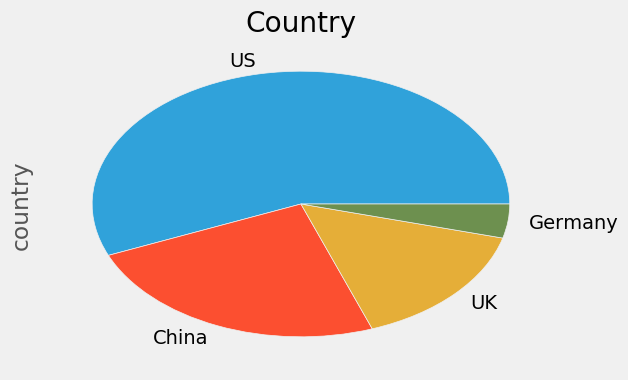

In [118]:
data = pd.read_csv('conversion_data.csv')

print('Original data shape, including features X and target y: \n{} \n'.format(data.shape))
print('Sample data: \n {}'.format(data.sample(n=5)))
print('\n Descriptive stats: \n {}'.format(data.describe()))

data['country'].value_counts().plot(kind='pie', title='Country')

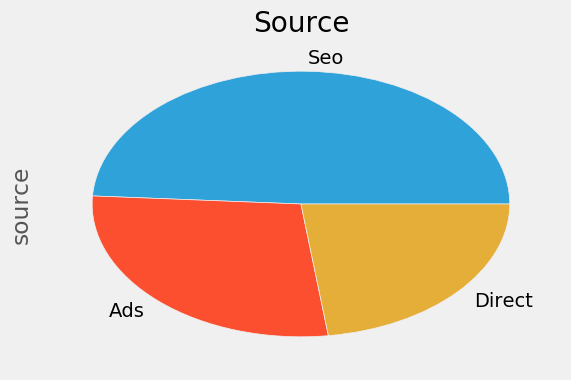

In [163]:
data['source'].value_counts().plot(kind='pie', title='Source')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x179cecd30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x17e4c5fd0>]], dtype=object)

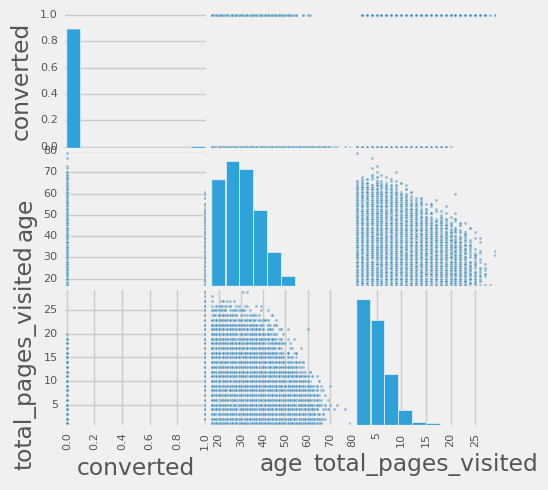

In [133]:
pd.scatter_matrix(data[['converted', 'age', 'total_pages_visited']], figsize=(5,5))

### Remove ages > 100

The oldest person in history lived 122 years, it is unlikely our 123 year old knows anything about the web.

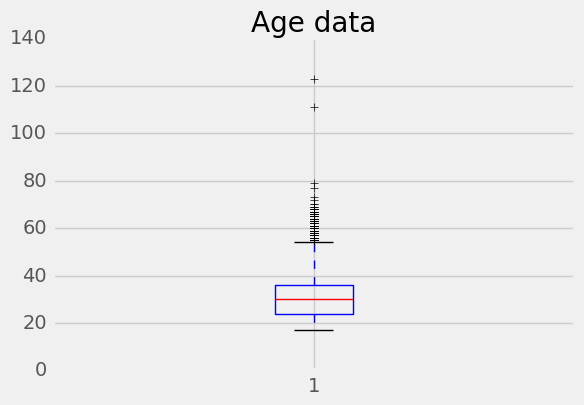

New shape after removing outliers: 
(316198, 6)


In [120]:
plt.title('Age data')
plt.boxplot(data['age'])
plt.show()

data = data.loc[data['age'] < 100]
print('New shape after removing outliers: \n{}'.format(data.shape))

### Convert categorical data, separate features from target

In [121]:
X = data.iloc[:,0:-1]
X = pd.get_dummies(X)

print('New columns after generating dummies: \n {}'.format(X.columns))
X = X.values
y = data['converted'].values

print('\n Target y shape: \n {}'.format(y.shape))
print('\n Feature matrix X shape: \n {} \n'.format(X.shape))
print(' Average for each new categorical feature:')
for a, b in zip(pd.get_dummies(data.iloc[:,0:-1]).columns[3:], pd.DataFrame(X).loc[:,3:9].mean()):
    print('  {}: {:.2f}'.format(a, b))

New columns after generating dummies: 
 Index(['age', 'new_user', 'total_pages_visited', 'country_China',
       'country_Germany', 'country_UK', 'country_US', 'source_Ads',
       'source_Direct', 'source_Seo'],
      dtype='object')

 Target y shape: 
 (316198,)

 Feature matrix X shape: 
 (316198, 10) 

 Average for each new categorical feature:
  country_China: 0.24
  country_Germany: 0.04
  country_UK: 0.15
  country_US: 0.56
  source_Ads: 0.28
  source_Direct: 0.23
  source_Seo: 0.49


### Scaling and preprocessing (PCA)

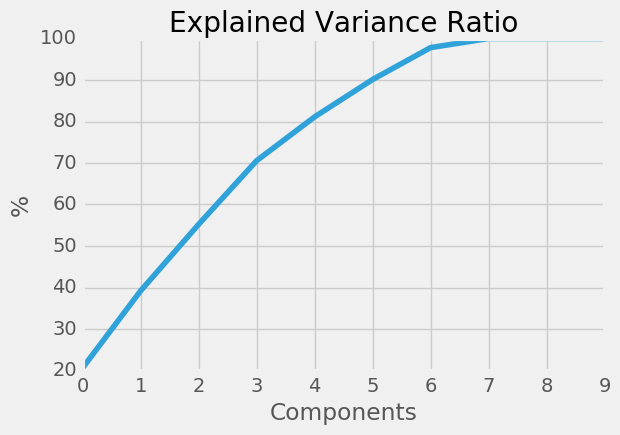

In [122]:
scaler = RobustScaler()
scaled_X = scaler.fit_transform(X)

pca = PCA(n_components=10)
pca.fit(scaled_X)

var = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.title('Explained Variance Ratio')
plt.xlabel('Components')
plt.ylabel('%')
plt.plot(var1)
plt.show()

# https://www.analyticsvidhya.com/blog/2016/03/practical-guide-principal-component-analysis-python/

### Train, test, split

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### K-Nearest Neighbors

In [138]:
# Step 1: Instantiate model
knn = KNeighborsClassifier()

# Step 2: Train model
knn.fit(X_train, y_train)
print(knn)

# Step 3: Evaluate
print('\n Training accuracy: {:.3f}'.format(knn.score(X_train, y_train)))
print('  Testing accuracy: {:.3f}'.format(knn.score(X_test, y_test)))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

 Training accuracy: 0.987
  Testing accuracy: 0.985


### Decision Tree Classifier

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Accuracy on train set: 0.988
Accuracy on test set: 0.985



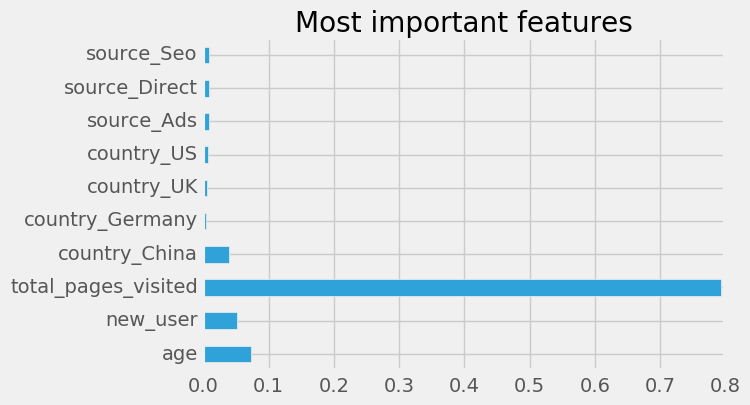

In [168]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
print(tree)
print('\nAccuracy on train set: {:.3f}'.format(tree.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}\n'.format(tree.score(X_test, y_test)))

col = pd.get_dummies(data.iloc[:,0:-1]).columns
df = pd.DataFrame(tree.feature_importances_, index=col, columns=['a'])
df.plot.barh(title='Most important features', legend=False)

# for a, b in zip(pd.get_dummies(data.iloc[:,0:-1]).columns, tree.feature_importances_):
#     print('{}: {:.3f}'.format(a, b))

# export_graphviz(tree, out_file='tree.dot')

### Linear Support Vector Machine

In [174]:
svm = LinearSVC()
svm.fit(X_train, y_train)
print(svm)
print('\n  Training accuracy: {:.3f}'.format(svm.score(X_train, y_train)))
print('   Testing accuracy: {:.3f}'.format(svm.score(X_test, y_test)))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

  Training accuracy: 0.985
   Testing accuracy: 0.986
